# DINOV2 WITH AND WITHOUT REGISTERS

In [1]:
# Copyright (c) Facebook, Inc. and its affiliates.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Note the original is here: https://github.com/facebookresearch/dino/blob/main/visualize_attention.py

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms as pth_transforms
import numpy as np
from PIL import Image
from dinov2.models.vision_transformer import vit_large
from dinov2.hub.backbones import dinov2_vitg14, dinov2_vitg14_reg
from torch.utils.data import DataLoader, Subset
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch.nn.functional as F
import seaborn as sns
from dinov2.utils.useful_functions import *

/Users/alisiasarabaielli/Desktop/UVA/FACT/dinov2_loc/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/Users/alisiasarabaielli/Desktop/UVA/FACT/dinov2_loc/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/Users/alisiasarabaielli/Desktop/UVA/FACT/dinov2_loc/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


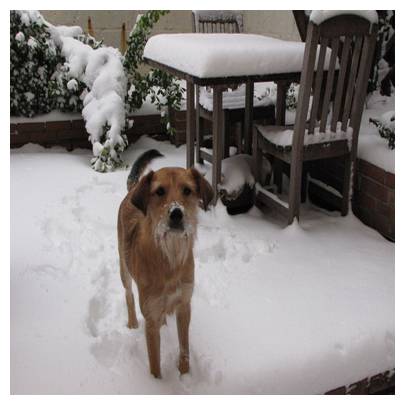

In [2]:
# input image
img = Image.open('dog.JPEG')
img = img.convert('RGB')
img =img.resize((952,952))


plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.axis("off")
#plt.title("Input Image")
plt.show()

## DINOV2 WITHOUT REG L

In [3]:
if __name__ == '__main__':
    image_size = (952, 952)
    output_dir = '.'
    patch_size = 14

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    model = vit_large(
            patch_size=14,
            img_size=526,
            init_values=1.0,
            block_chunks=0
    )

    model.load_state_dict(torch.load('dinov2_vitl14_pretrain.pth'))
    for p in model.parameters():
        p.requires_grad = False
    model.to(device)
    model.eval()

    img = Image.open('dog.JPEG')
    img = img.convert('RGB')
    transform = pth_transforms.Compose([
        pth_transforms.Resize(image_size),
        pth_transforms.ToTensor(),
    ])
    img = transform(img)
    print(img.shape)

    w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - img.shape[2] % patch_size
    img = img[:, :w, :h].unsqueeze(0)

    w_featmap = img.shape[-2] // patch_size
    h_featmap = img.shape[-1] // patch_size

    print(img.shape)

    attentions = model.get_last_self_attention(img.to(device))

    nh = attentions.shape[1] 
    attentions = attentions[0, :, 0, :]

    attentions = attentions[:, 1:].reshape(nh, w_featmap, h_featmap)
    attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()


torch.Size([3, 952, 952])
torch.Size([1, 3, 952, 952])
Inside get_last_self_attention
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


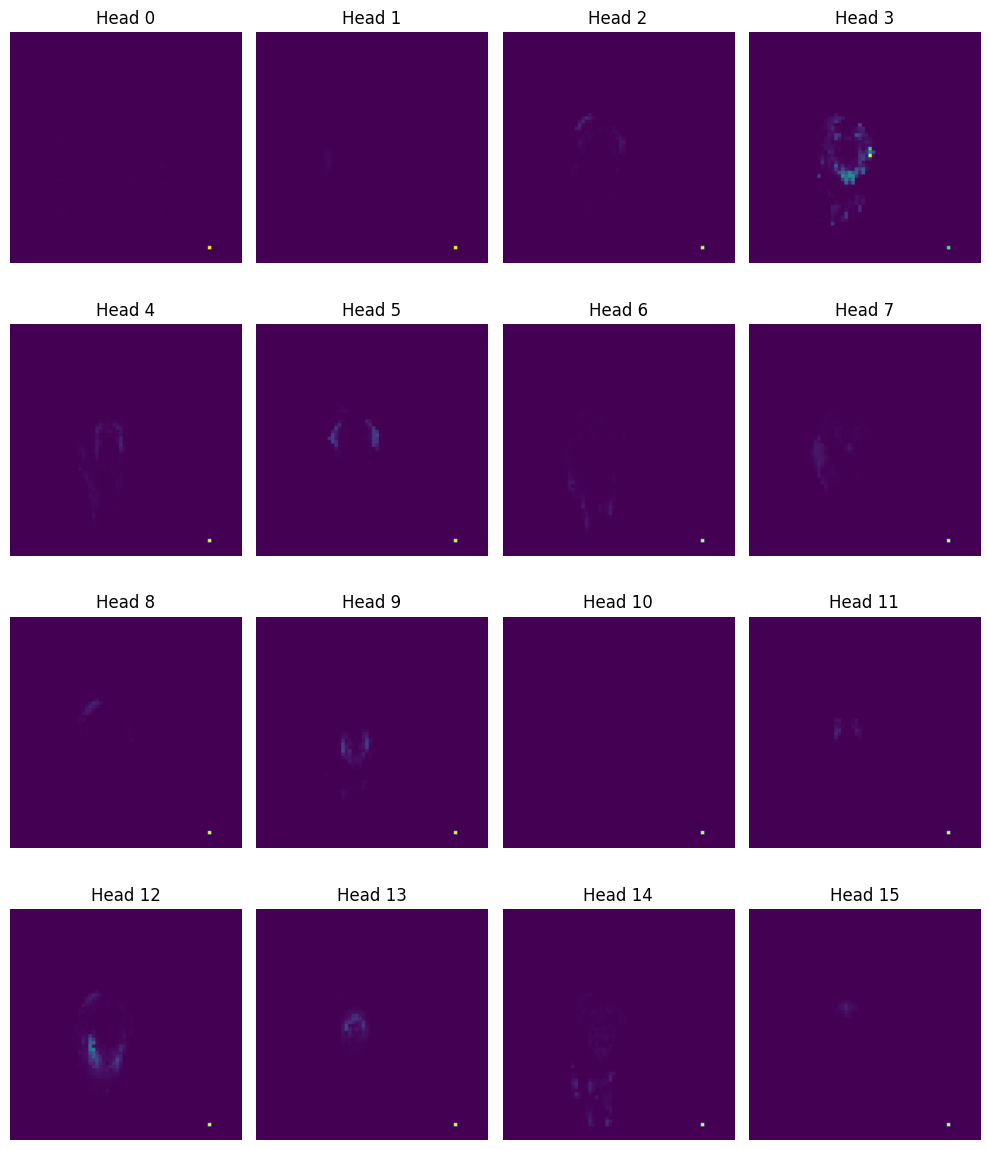

In [4]:

num_cols = 4
num_rows = (nh + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, num_rows * 3))

# Plot all attention maps
for j in range(nh):
    row, col = divmod(j, num_cols)
    ax = axes[row, col]
    ax.imshow(attentions[j], cmap="viridis")
    ax.set_title(f"Head {j}")
    ax.axis("off")

for idx in range(nh, num_rows * num_cols):
    axes[idx // num_cols, idx % num_cols].axis("off")

plt.tight_layout()
plt.show()


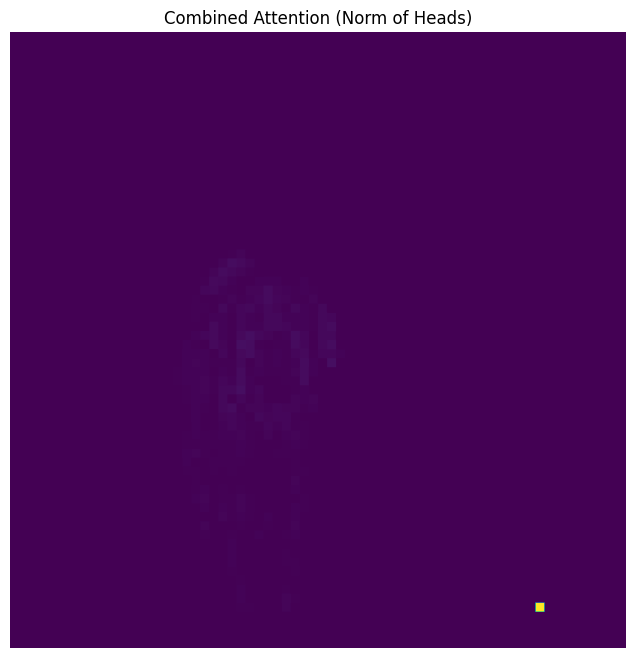

In [5]:
# DINOV2 HEAD NORM

combined_attention = np.linalg.norm(attentions, axis=0)

plt.figure(figsize=(8, 8))
plt.imshow(combined_attention, cmap="viridis")
plt.title("Combined Attention (Norm of Heads)")
plt.axis("off")
#plt.colorbar(label="Attention Norm")
plt.show()


### Log-scale

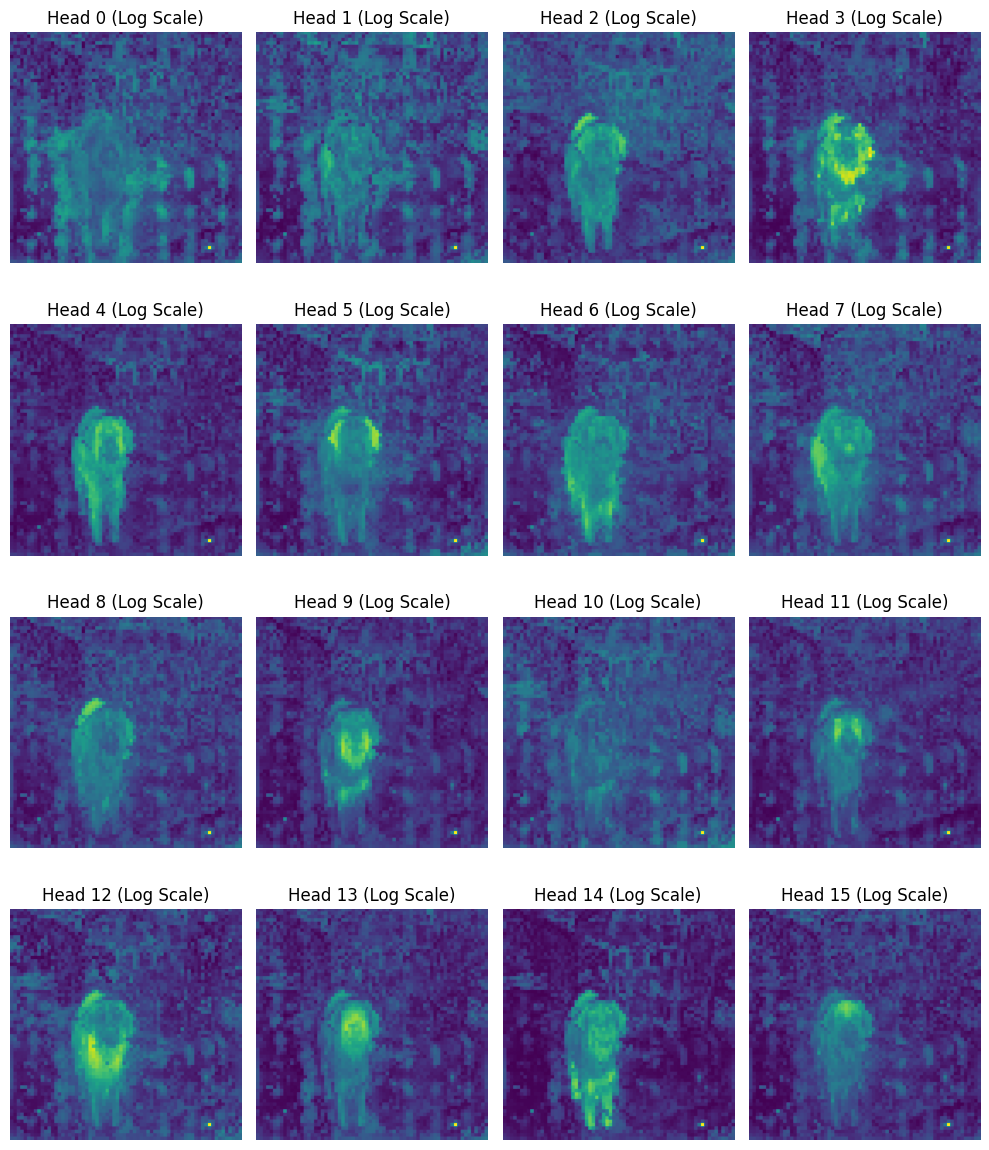

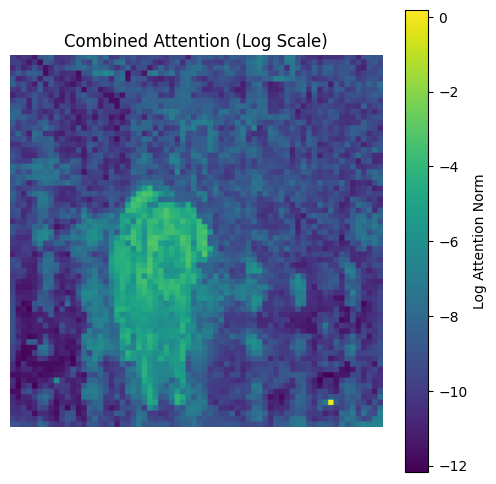

In [ ]:
# log scale visualization

epsilon = 1e-6  # small constant to prevent log(0)

log_attentions = np.log(attentions + epsilon)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, num_rows * 3))
for j in range(nh):
    row, col = divmod(j, num_cols)
    ax = axes[row, col]
    ax.imshow(log_attentions[j], cmap="viridis")
    ax.set_title(f"Head {j} (Log Scale)")
    ax.axis("off")

for idx in range(nh, num_rows * num_cols):
    axes[idx // num_cols, idx % num_cols].axis("off")

plt.tight_layout()
plt.show()

combined_attention_log = np.log(combined_attention + epsilon)

plt.figure(figsize=(6, 6))
plt.imshow(combined_attention_log, cmap="viridis")
plt.title("Combined Attention (Log Scale)")
plt.axis("off")
plt.colorbar(label="Log Attention Norm")
plt.show()


### Feature norms

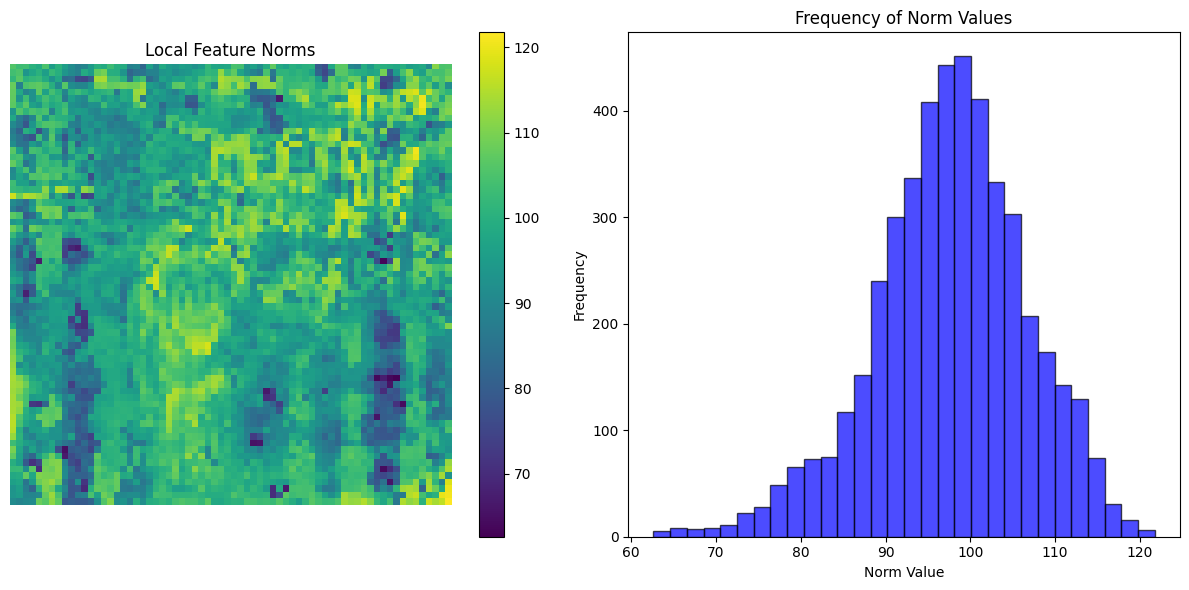

In [6]:
# DINOV2 NORMS WITHOUT REGISTERS

features = model.forward_features(img)["x_prenorm"]

patch_features = features[:, 1:, :]
local_feature_norms = torch.norm(patch_features, dim=-1)

w_featmap = img.shape[-2] // patch_size
h_featmap = img.shape[-1] // patch_size
local_feature_norms = local_feature_norms.reshape(-1, w_featmap, h_featmap)

flattened_norms = local_feature_norms[0].cpu().numpy().flatten()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(local_feature_norms[0].cpu().numpy(), cmap="viridis")
plt.colorbar()
plt.title("Local Feature Norms")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.hist(flattened_norms, bins=30, color="blue", alpha=0.7, edgecolor="black")
plt.title("Frequency of Norm Values")
plt.xlabel("Norm Value")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


### Cosine similarity

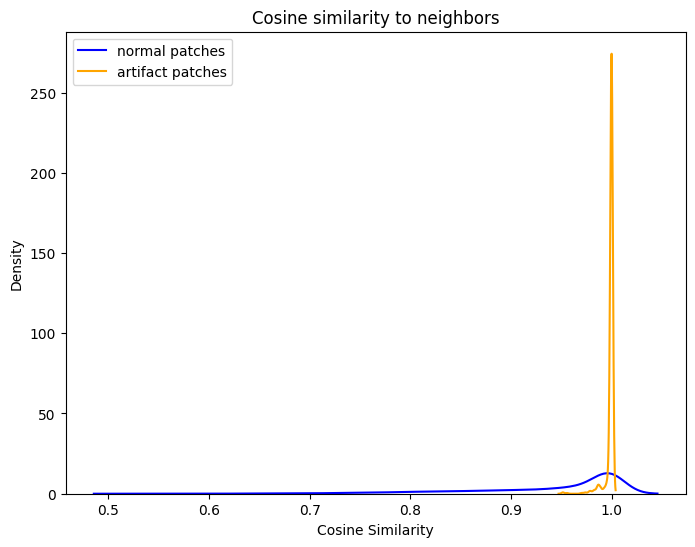

In [7]:
# Neighbor cosine similarity dinov2 large

image_size = (952, 952)
patch_size = 14
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

img = Image.open("dog.JPEG").convert("RGB")
transform = pth_transforms.Compose([
    pth_transforms.Resize(image_size),
    pth_transforms.ToTensor(),
])
img = transform(img).unsqueeze(0)
img = img[:, :, :img.shape[2] - img.shape[2] % patch_size, :img.shape[3] - img.shape[3] % patch_size]
img = img.to(device)

model = vit_large(patch_size=patch_size, img_size=image_size[0])
model.to(device)
model.eval()

with torch.no_grad():
    patch_embeddings = model.patch_embed(img)

B, num_patches, embed_dim = patch_embeddings.shape
grid_size = int(num_patches**0.5)
patch_embeddings = patch_embeddings.view(B, grid_size, grid_size, embed_dim)
norms = torch.norm(patch_embeddings, dim=-1)

threshold = torch.quantile(norms, 0.85)
artifact_indices = torch.nonzero(norms > threshold, as_tuple=True)
normal_indices = torch.nonzero(norms <= threshold, as_tuple=True)

artifact_similarities = compute_average_cosine_similarities(artifact_indices, patch_embeddings, num_patches)
normal_similarities = compute_average_cosine_similarities(normal_indices, patch_embeddings,  num_patches)

plt.figure(figsize=(8, 6))
sns.kdeplot(normal_similarities, label="normal patches", color="blue")
sns.kdeplot(artifact_similarities, label="artifact patches", color="orange")
plt.title("Cosine similarity to neighbors")
plt.xlabel("Cosine Similarity")
plt.ylabel("Density")
plt.legend()
plt.show()


### Global attention check

Mean norm for high-attention patches: 105.83338165283203


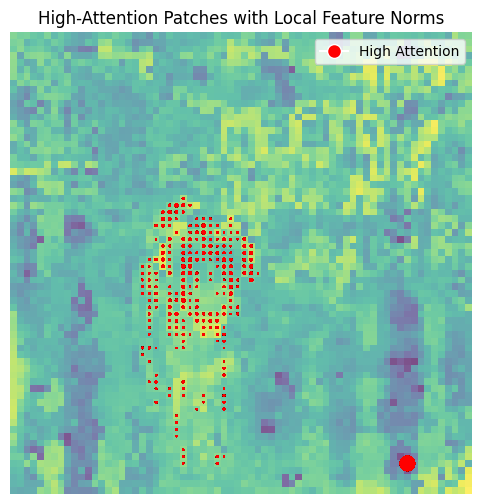

In [ ]:
# check if high norms correspond to high attention values

high_attention_threshold = np.percentile(combined_attention, 95)
high_attention_indices = np.where(combined_attention >= high_attention_threshold)

scale_factor = 196 // 14
scaled_attention_indices = (high_attention_indices[0] // scale_factor, high_attention_indices[1] // scale_factor)

attention_values = combined_attention[high_attention_indices]

high_attention_norms = local_feature_norms[0].cpu().numpy()[scaled_attention_indices]

mean_high_attention_norm = np.mean(high_attention_norms)
print(f"Mean norm for high-attention patches: {mean_high_attention_norm}")

dot_sizes = (attention_values - np.min(attention_values)) / (np.max(attention_values) - np.min(attention_values)) * 100

plt.figure(figsize=(6, 6))
plt.imshow(local_feature_norms[0].cpu().numpy(), cmap="viridis", alpha=0.7)
plt.scatter(scaled_attention_indices[1], scaled_attention_indices[0], color="red", s=dot_sizes)
#
#plt.colorbar(label='Norm Values')
plt.title("High-Attention Patches with Local Feature Norms")
plt.axis("off")
plt.legend(
    handles=[plt.Line2D([0], [0], marker='o', color='w', label='High Attention',
                        markerfacecolor='red', markersize=10)],
    loc='upper right', frameon=True, fontsize=10
)

plt.show()


In [9]:
# logistic regression norm-normal 3 seeds

seeds = [42, 123, 999]
train_subset_size = 800
test_subset_size = 200
batch_size = 100
high_norm_accuracies = []
normal_norm_accuracies = []

for seed in seeds:
    high_acc, normal_acc = run_3glo_l(seed)
    high_norm_accuracies.append(high_acc)
    normal_norm_accuracies.append(normal_acc)

avg_high_acc = np.mean(high_norm_accuracies)
avg_normal_acc = np.mean(normal_norm_accuracies)

print("\nAverage Results over 3 runs:")
print(f"Average High-Norm Token Accuracy: {avg_high_acc:.4f}")
print(f"Average Normal Token Accuracy: {avg_normal_acc:.4f}")


Running experiment with seed 42...
Files already downloaded and verified
Files already downloaded and verified
Subsets and DataLoaders ready.
DINOv2 model loaded and ready.
Extracting patch embeddings...
Processed batch 1/8
Processed batch 2/8
Processed batch 3/8
Processed batch 4/8
Processed batch 5/8
Processed batch 6/8
Processed batch 7/8
Processed batch 8/8
Patch embedding extraction complete.
800 800
800 800
Training Logistic Regression classifiers...
Evaluating classifiers...
High-Norm Token Accuracy: 0.9625
Normal Token Accuracy: 0.8688
Running experiment with seed 123...
Files already downloaded and verified
Files already downloaded and verified
Subsets and DataLoaders ready.
DINOv2 model loaded and ready.
Extracting patch embeddings...
Processed batch 1/8
Processed batch 2/8
Processed batch 3/8
Processed batch 4/8
Processed batch 5/8
Processed batch 6/8
Processed batch 7/8
Processed batch 8/8
Patch embedding extraction complete.
800 800
800 800
Training Logistic Regression cla

Processing layer 0...
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Layer 0 completed
Processing layer 1...
Layer 1 completed
Processing layer 2...
Layer 2 completed
Processing layer 3...
Layer 3 completed
Processing layer 4...
Layer 4 completed
Processing layer 5...
Layer 5 completed
Processing layer 6...
Layer 6 completed
Processing layer 7...
Layer 7 completed
Processing layer 8...
Layer 8 completed
Processing layer 9...
Layer 9 completed
Processing layer 10...
Layer 10 completed
Processing layer 11...
Layer 11 completed
Processing layer 12...
Layer 12 completed
Processing layer 13...
Layer 13 completed
Processing layer 14...
Layer 14 completed
Processing layer 15...
Layer 15 completed
Processing layer 16...
Layer 16 completed
Processing layer 17...
Layer 17 completed
Processing lay

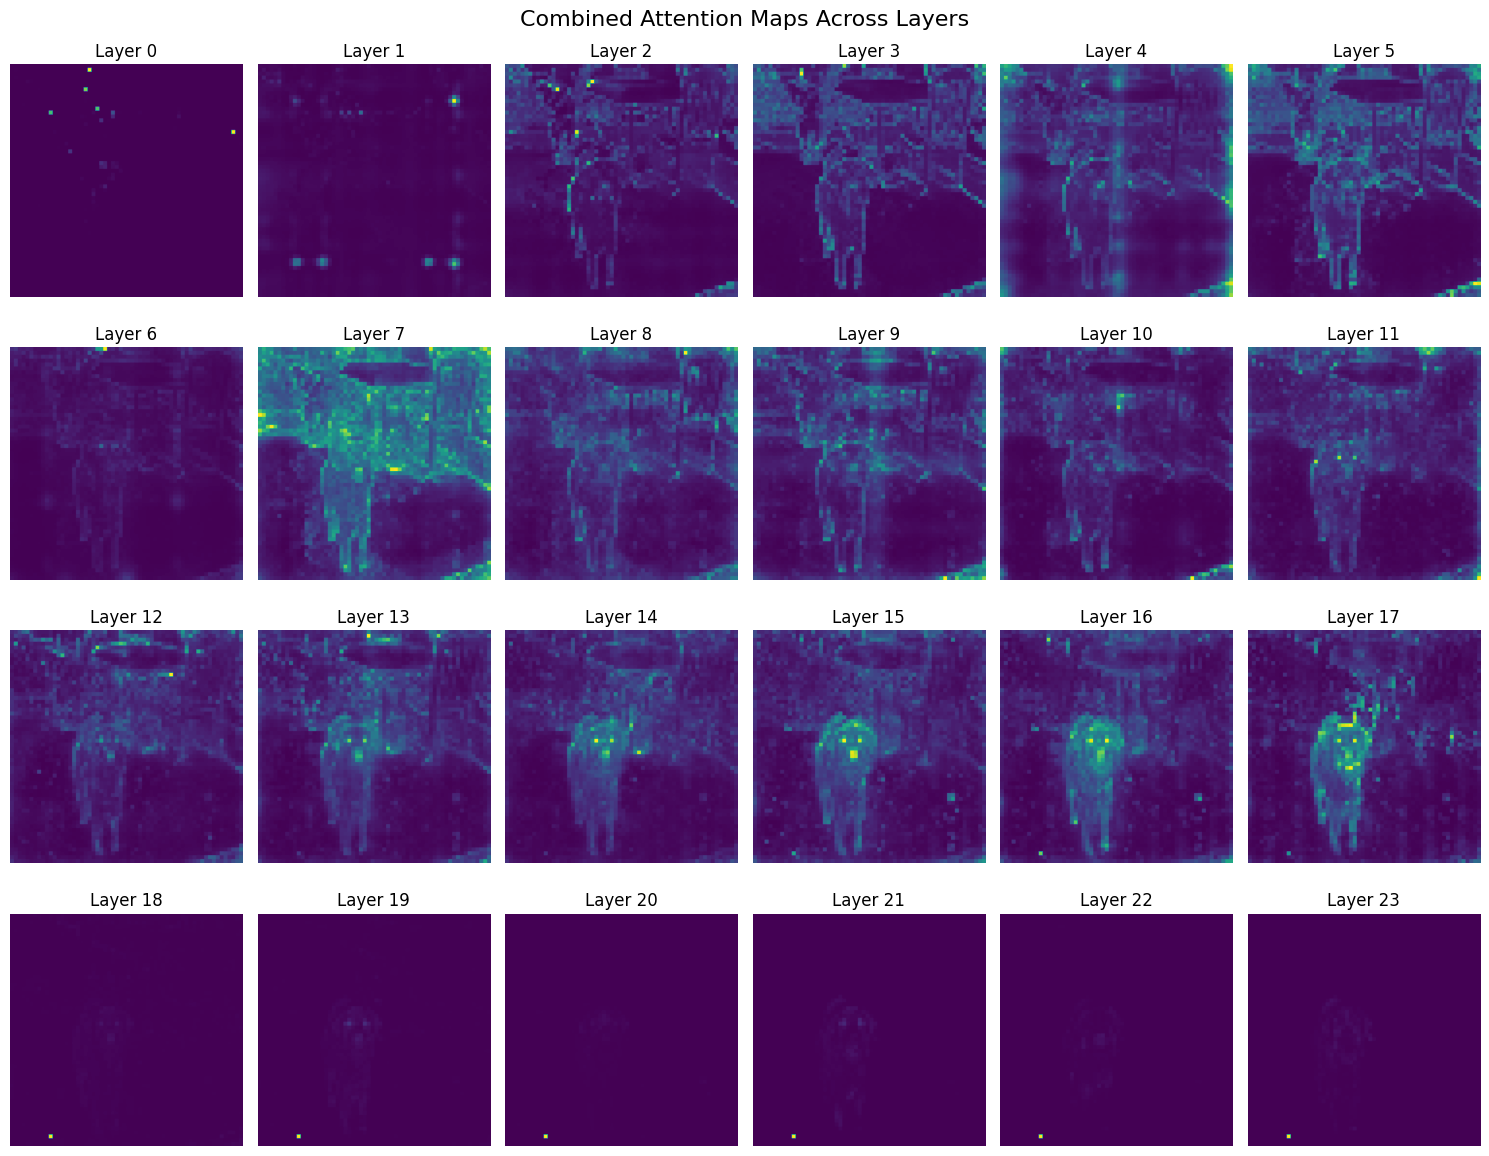

In [ ]:
# Attention across layers

if __name__ == '__main__':

    image_size = (840, 840)
    patch_size = 14

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    model = vit_large(
        patch_size=patch_size,
        img_size=526,
        init_values=1.0,
        block_chunks=0
    )

    model.load_state_dict(torch.load('dinov2_vitl14_pretrain.pth'))
    for p in model.parameters():
        p.requires_grad = False
    model.to(device)
    model.eval()

    img = Image.open('dog.JPEG')
    img = img.convert('RGB')
    transform = pth_transforms.Compose([
        pth_transforms.Resize(image_size),
        pth_transforms.ToTensor(),
    ])
    img = transform(img)
    w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - img.shape[2] % patch_size
    img = img[:, :w, :h].unsqueeze(0)

    w_featmap = img.shape[-2] // patch_size
    h_featmap = img.shape[-1] // patch_size

    all_layer_attentions = []

    x = model.prepare_tokens_with_masks(img.to(device))
    for layer_idx, blk in enumerate(model.blocks):
        print(f"Processing layer {layer_idx}...")
        attention = blk(x, return_attention=True)
        all_layer_attentions.append(attention)
        x = blk(x)
        print(f"Layer {layer_idx} completed")
    num_layers = len(all_layer_attentions)
    num_cols = 6
    num_rows = (num_layers + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows*3))
    fig.suptitle("Combined Attention Maps Across Layers", fontsize=16)

    for layer_idx, attentions in enumerate(all_layer_attentions):
        nh = attentions.shape[1]
        attentions = attentions[0, :, 0, :]
        attentions = attentions[:, 1:].reshape(nh, w_featmap, h_featmap)
        attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()

        combined_attention = np.linalg.norm(attentions, axis=0)


        row, col = divmod(layer_idx, num_cols)
        ax = axes[row, col]
        ax.imshow(combined_attention, cmap="viridis")
        ax.set_title(f"Layer {layer_idx}")
        ax.axis("off")

    for idx in range(num_layers, num_rows * num_cols):
        row, col = divmod(idx, num_cols)
        axes[row, col].axis("off")

    plt.tight_layout()
    plt.show()


### Local attention check

In [10]:
# Position prediction 3 seeds

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = vit_large(
    patch_size=14,
    img_size=526,
    init_values=1.0,
    block_chunks=0
)
model.load_state_dict(torch.load('dinov2_vitl14_pretrain.pth'))
for p in model.parameters():
    p.requires_grad = False
model.to(device)
model.eval()

transform = pth_transforms.Compose([
    pth_transforms.Resize((196, 196)),
    pth_transforms.ToTensor()
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_subset_size = 800
test_subset_size = 200
train_indices = torch.randperm(len(train_dataset))[:train_subset_size]
test_indices = torch.randperm(len(test_dataset))[:test_subset_size]
train_subset = Subset(train_dataset, train_indices)
test_subset = Subset(test_dataset, test_indices)

train_loader = DataLoader(train_subset, batch_size=10, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=10, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
train_embeddings, train_positions, train_norms = extract_features_loc(model, train_loader)
test_embeddings, test_positions, test_norms = extract_features_loc(model, test_loader)

high_indices = train_norms > 100
normal_indices = ~high_indices

X_high = train_embeddings[high_indices]
y_high = train_positions[high_indices]
X_normal = train_embeddings[normal_indices]
y_normal = train_positions[normal_indices]

Extracting patch embeddings and positional information...
Complete.
Extracting patch embeddings and positional information...
Complete.


In [13]:
high_norm_top1_accs = []
high_norm_avg_distances = []
normal_top1_accs = []
normal_avg_distances = []

seeds = [42, 123, 999]

for seed in seeds:
    print(f"Running experiment with seed {seed}...")
    high_top1_acc, high_avg_dist, normal_top1_acc, normal_avg_dist = run_3loc(seed, X_high, X_normal, y_high, y_normal)
    high_norm_top1_accs.append(high_top1_acc)
    high_norm_avg_distances.append(high_avg_dist)
    normal_top1_accs.append(normal_top1_acc)
    normal_avg_distances.append(normal_avg_dist)

high_top1_acc_mean = np.mean(high_norm_top1_accs)
high_avg_dist_mean = np.mean(high_norm_avg_distances)
normal_top1_acc_mean = np.mean(normal_top1_accs)
normal_avg_dist_mean = np.mean(normal_avg_distances)

print("\nAverage Results over 3 runs:")
print(f"High-Norm Tokens - Avg Top-1 Accuracy: {high_top1_acc_mean:.2f}% | Avg Distance: {high_avg_dist_mean:.2f}")
print(f"Normal Tokens - Avg Top-1 Accuracy: {normal_top1_acc_mean:.2f}% | Avg Distance: {normal_avg_dist_mean:.2f}")


Running experiment with seed 42...
Running experiment with seed 123...
Running experiment with seed 999...

Average Results over 3 runs:
High-Norm Tokens - Avg Top-1 Accuracy: 1.53% | Avg Distance: 5.09
Normal Tokens - Avg Top-1 Accuracy: 13.82% | Avg Distance: 1.38


## DINOV2 WITH REG L

In [ ]:
if __name__ == '__main__':
    image_size = (952, 952)
    output_dir = '.'
    patch_size = 14

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    model_reg = vit_large(
        patch_size=14,
        img_size=526,
        init_values=1.0,
        block_chunks=0,
        num_register_tokens=4,
    )

    state_dict = torch.load('dinov2_vitl14_reg4_pretrain.pth')
    model_reg.load_state_dict(state_dict, strict=True)

    for p in model_reg.parameters():
        p.requires_grad = False
    model_reg.to(device)
    model_reg.eval()

    # Process the input image
    img = Image.open('dog.JPEG')
    img = img.convert('RGB')
    transform = pth_transforms.Compose([
        pth_transforms.Resize(image_size),
        pth_transforms.ToTensor(),
    ])
    img = transform(img)
    w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - img.shape[2] % patch_size
    img = img[:, :w, :h].unsqueeze(0)

    w_featmap = img.shape[-2] // patch_size
    h_featmap = img.shape[-1] // patch_size
    print(f"Feature map size: {w_featmap} x {h_featmap}")

    attentions = model_reg.get_last_self_attention(img.to(device))
    nh = attentions.shape[1]

    attentions = attentions[0, :, 0, :]
    num_patches = w_featmap * h_featmap
    expected_tokens = 1 + 4 + num_patches
    if attentions.size(1) != expected_tokens:
        raise RuntimeError(
            f"Token mismatch: expected {expected_tokens} tokens, but got {attentions.size(1)} tokens."
        )

    attentions = torch.cat([attentions[:, :1], attentions[:, 5:]], dim=1)
    attentions = attentions[:, 1:].reshape(nh, w_featmap, h_featmap)

    attentions = nn.functional.interpolate(
        attentions.unsqueeze(0), scale_factor=patch_size, mode="nearest"
    )[0].cpu().numpy()

Feature map size: 68 x 68
Inside get_last_self_attention
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


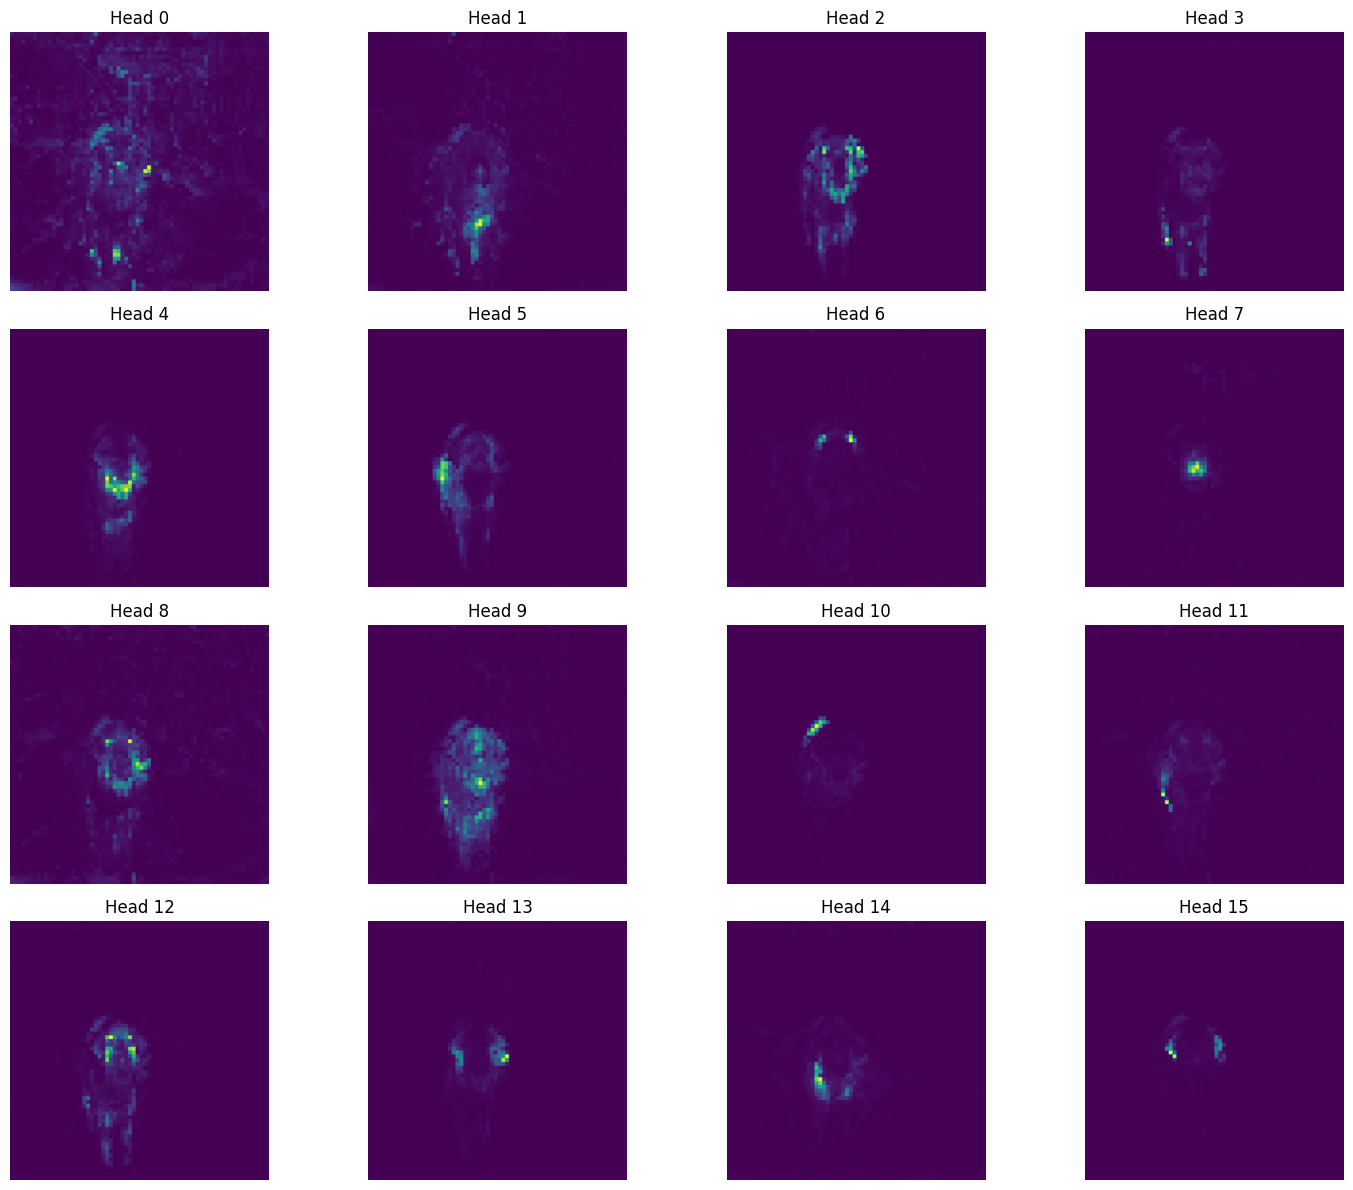

In [ ]:

num_cols = 4
num_rows = (nh + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))

for j in range(nh):
    row, col = divmod(j, num_cols)
    ax = axes[row, col]
    ax.imshow(attentions[j], cmap="viridis")
    ax.set_title(f"Head {j}")
    ax.axis("off")

for idx in range(nh, num_rows * num_cols):
    axes[idx // num_cols, idx % num_cols].axis("off")

plt.tight_layout()
plt.show()


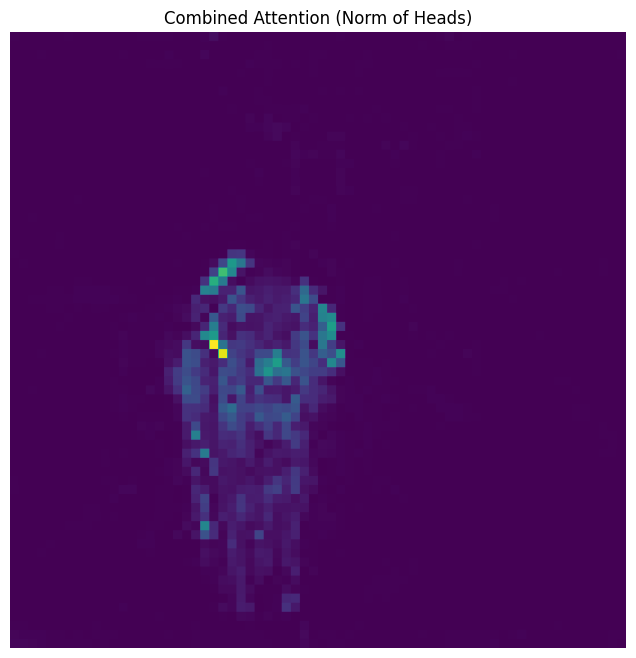

In [ ]:
# DINOV2 HEAD NORM

combined_attention = np.linalg.norm(attentions, axis=0)

plt.figure(figsize=(8, 8))
plt.imshow(combined_attention, cmap="viridis")
plt.title("Combined Attention (Norm of Heads)")
plt.axis("off")
#plt.colorbar(label="Attention Norm")
plt.show()

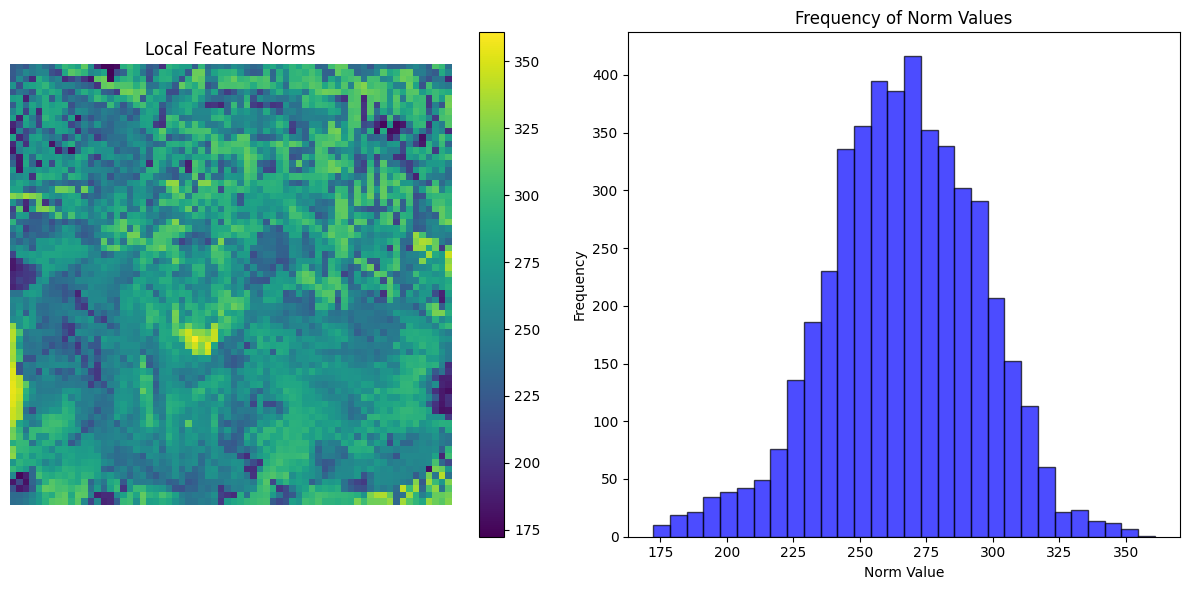

In [ ]:
# DINOV2 NORMS WITH REGISTERS

features = model_reg.forward_features(img)["x_prenorm"]
patch_features = features[:, 1 + 4:, :]
local_feature_norms = torch.norm(patch_features, dim=-1)
w_featmap = img.shape[-2] // patch_size
h_featmap = img.shape[-1] // patch_size


num_patches = patch_features.shape[1]
local_feature_norms = local_feature_norms.reshape(-1, w_featmap, h_featmap)

flattened_norms = local_feature_norms[0].cpu().numpy().flatten()
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(local_feature_norms[0].cpu().numpy(), cmap="viridis")
plt.colorbar()
plt.title("Local Feature Norms")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.hist(flattened_norms, bins=30, color="blue", alpha=0.7, edgecolor="black")
plt.title("Frequency of Norm Values")
plt.xlabel("Norm Value")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


## PERFORMANCE REGRESSION WITH/WITHOUT REG L

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_no_reg = vit_large(
    patch_size=14,
    img_size=526,
    init_values=1.0,
    block_chunks=0
)
model_no_reg.load_state_dict(torch.load('dinov2_vitl14_pretrain.pth'))
model_no_reg.to(device)
model_no_reg.eval()

model_with_reg = vit_large(
    patch_size=14,
    img_size=526,
    init_values=1.0,
    block_chunks=0,
    num_register_tokens=4
)
model_with_reg.load_state_dict(torch.load('dinov2_vitl14_reg4_pretrain.pth'))
model_with_reg.to(device)
model_with_reg.eval()

transform = pth_transforms.Compose([
    pth_transforms.Resize((196, 196)),
    pth_transforms.ToTensor()
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_subset_size = 800
test_subset_size = 200
train_indices = torch.randperm(len(train_dataset))[:train_subset_size]
test_indices = torch.randperm(len(test_dataset))[:test_subset_size]

train_subset = Subset(train_dataset, train_indices)
test_subset = Subset(test_dataset, test_indices)
train_loader = DataLoader(train_subset, batch_size=10, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=10, shuffle=False)

print("Extracting features for model without registers...")
train_features_no_reg, train_labels_no_reg = extract_features(model_no_reg, train_loader)
test_features_no_reg, test_labels_no_reg = extract_features(model_no_reg, test_loader)

print("Extracting features for model with registers...")
train_features_with_reg, train_labels_with_reg = extract_features(model_with_reg, train_loader)
test_features_with_reg, test_labels_with_reg = extract_features(model_with_reg, test_loader)

print("Evaluating model without registers...")
accuracy_no_reg = evaluate_linear_probe(
    train_features_no_reg, train_labels_no_reg,
    test_features_no_reg, test_labels_no_reg
)

print("Evaluating model with registers...")
accuracy_with_reg = evaluate_linear_probe(
    train_features_with_reg, train_labels_with_reg,
    test_features_with_reg, test_labels_with_reg
)

print(f"Accuracy without registers: {accuracy_no_reg:.4f}")
print(f"Accuracy with registers: {accuracy_with_reg:.4f}")

Files already downloaded and verified
Files already downloaded and verified
Extracting features for model without registers...
Extracting features for model with registers...
Evaluating model without registers...
Evaluating model with registers...
Accuracy without registers: 0.9750
Accuracy with registers: 0.9950


## DINOV2 WITHOUT REG G

In [ ]:
if __name__ == '__main__':
    image_size = (952, 952)
    output_dir = '.'
    patch_size = 14

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    model = dinov2_vitg14(
            patch_size=14,
            img_size=526,
            init_values=1.0,
            block_chunks=0
    )

    model.load_state_dict(torch.load('dinov2_vitg14_pretrain.pth'))
    for p in model.parameters():
        p.requires_grad = False
    model.to(device)
    model.eval()

    img = Image.open('dog.JPEG')
    img = img.convert('RGB')
    transform = pth_transforms.Compose([
        pth_transforms.Resize(image_size),
        pth_transforms.ToTensor(),
    ])
    img = transform(img)
    print(img.shape)

    w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - img.shape[2] % patch_size
    img = img[:, :w, :h].unsqueeze(0)

    w_featmap = img.shape[-2] // patch_size
    h_featmap = img.shape[-1] // patch_size

    print(img.shape)

    attentions = model.get_last_self_attention(img.to(device))

    nh = attentions.shape[1] 
    attentions = attentions[0, :, 0, :]

    attentions = attentions[:, 1:].reshape(nh, w_featmap, h_featmap)
    attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()


torch.Size([3, 952, 952])
torch.Size([1, 3, 952, 952])
Inside get_last_self_attention
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


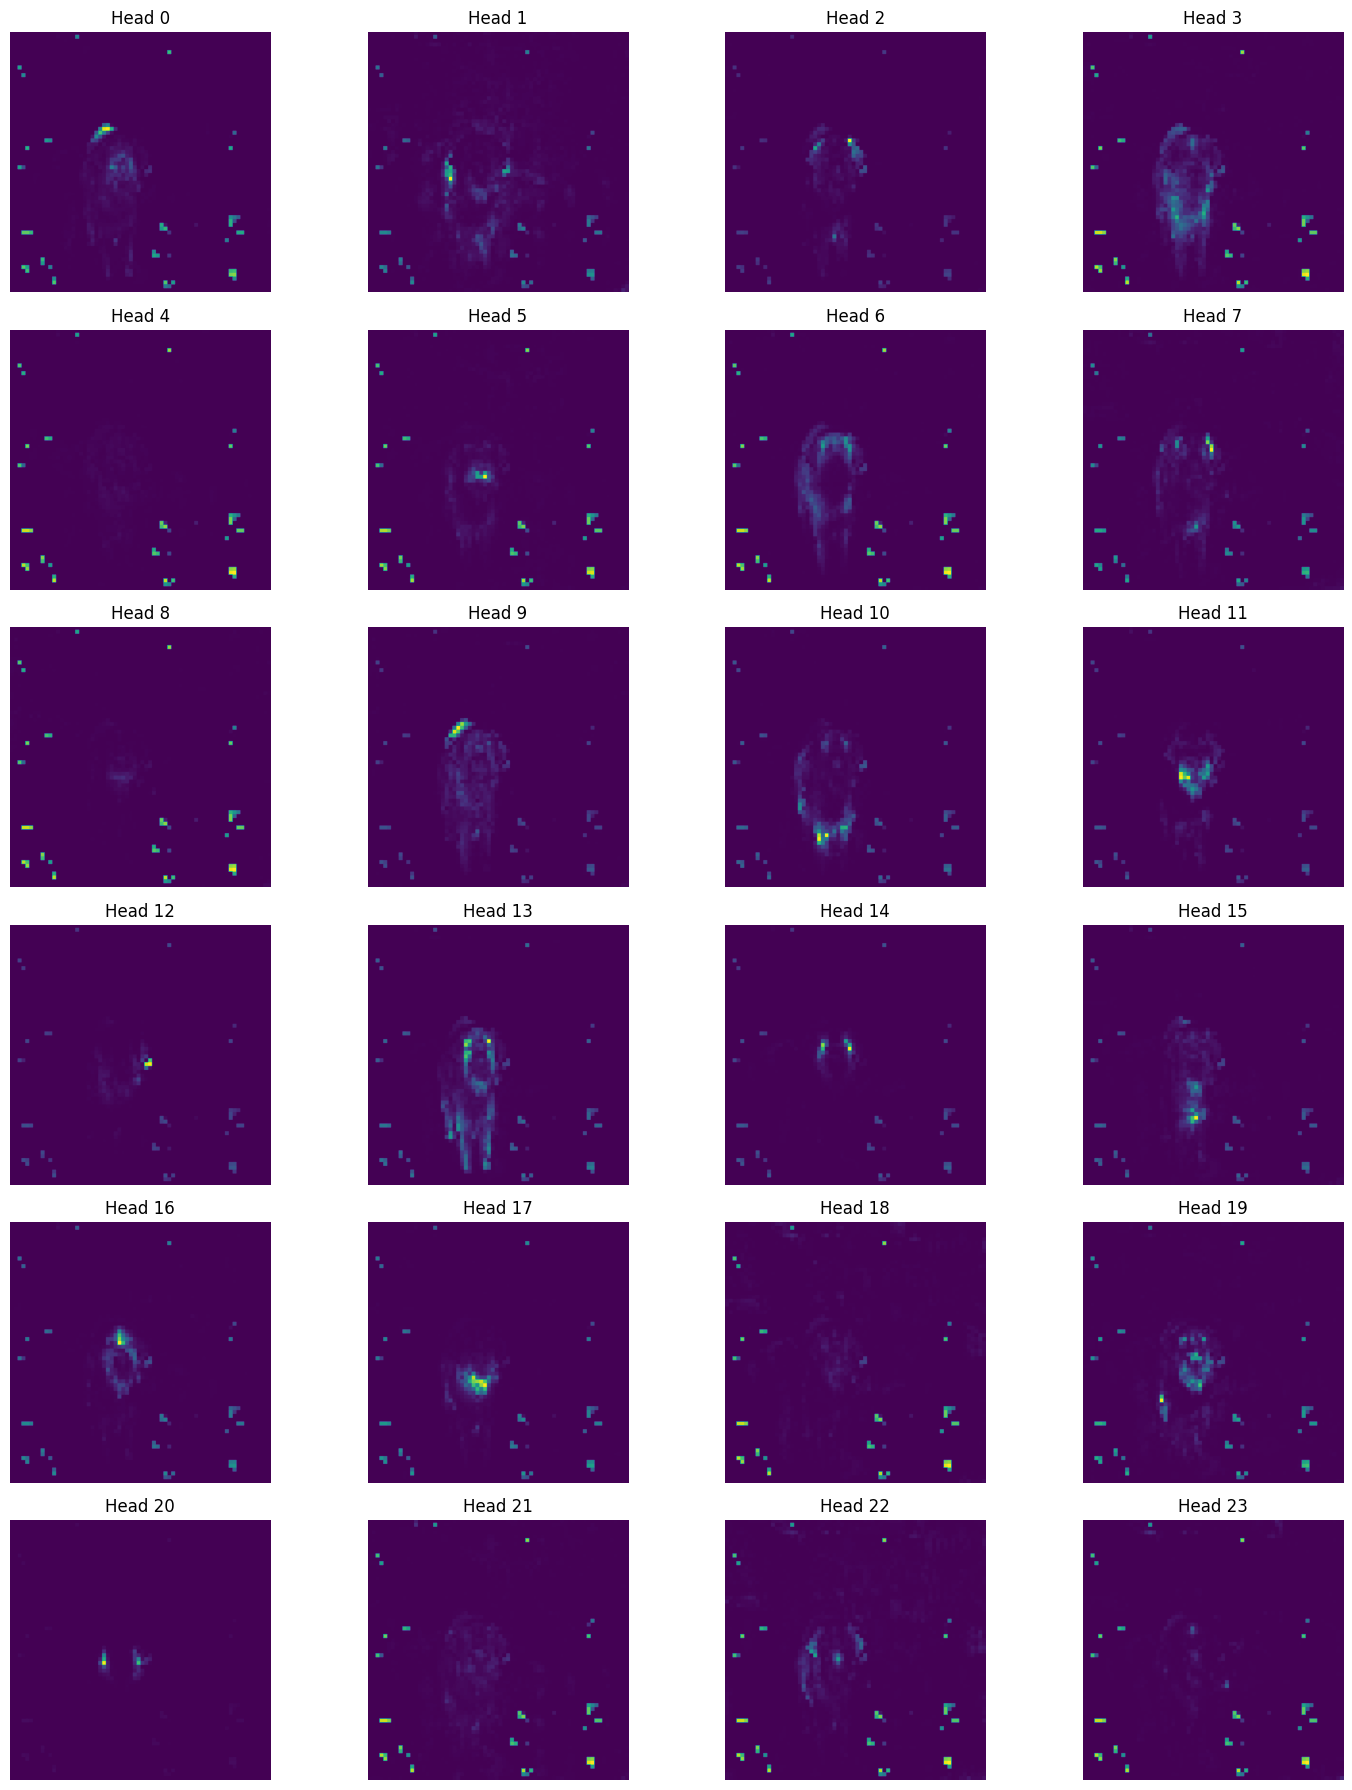

In [ ]:

num_cols = 4
num_rows = (nh + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))

for j in range(nh):
    row, col = divmod(j, num_cols)
    ax = axes[row, col]
    ax.imshow(attentions[j], cmap="viridis")
    ax.set_title(f"Head {j}")
    ax.axis("off")

for idx in range(nh, num_rows * num_cols):
    axes[idx // num_cols, idx % num_cols].axis("off")

plt.tight_layout()
plt.show()

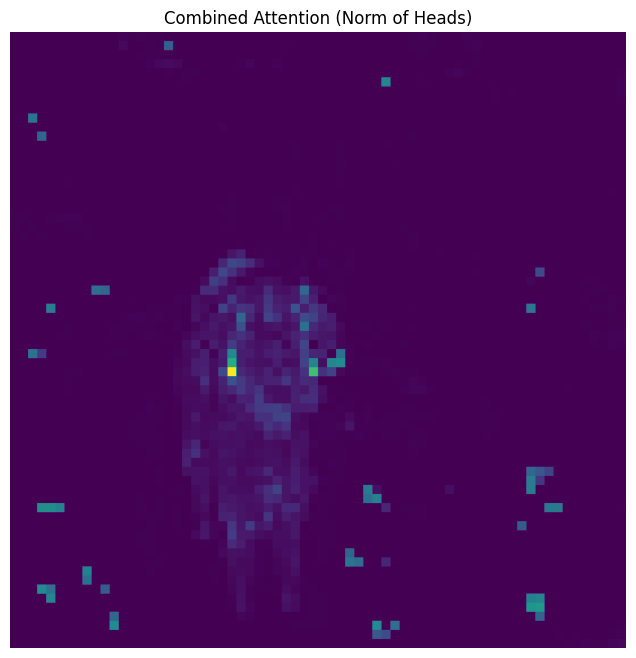

In [ ]:
# DINOV2 HEAD NORM

combined_attention = np.linalg.norm(attentions, axis=0)

plt.figure(figsize=(8, 8))
plt.imshow(combined_attention, cmap="viridis")
plt.title("Combined Attention (Norm of Heads)")
plt.axis("off")
#plt.colorbar(label="Attention Norm")
plt.show()


### Feature norms

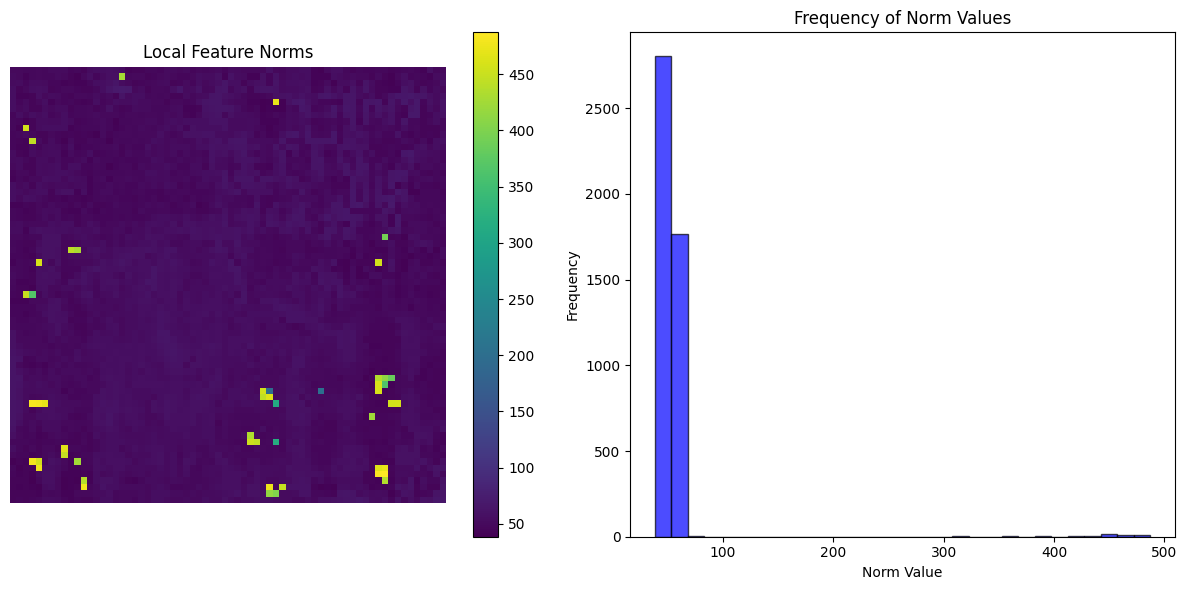

In [ ]:
# DINOV2 NORMS WITHOUT REGISTERS

features = model.forward_features(img)["x_prenorm"]

patch_features = features[:, 1:, :]
local_feature_norms = torch.norm(patch_features, dim=-1)

w_featmap = img.shape[-2] // patch_size
h_featmap = img.shape[-1] // patch_size
local_feature_norms = local_feature_norms.reshape(-1, w_featmap, h_featmap)

flattened_norms = local_feature_norms[0].cpu().numpy().flatten()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(local_feature_norms[0].cpu().numpy(), cmap="viridis")
plt.colorbar()
plt.title("Local Feature Norms")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.hist(flattened_norms, bins=30, color="blue", alpha=0.7, edgecolor="black")
plt.title("Frequency of Norm Values")
plt.xlabel("Norm Value")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

### Log-scale

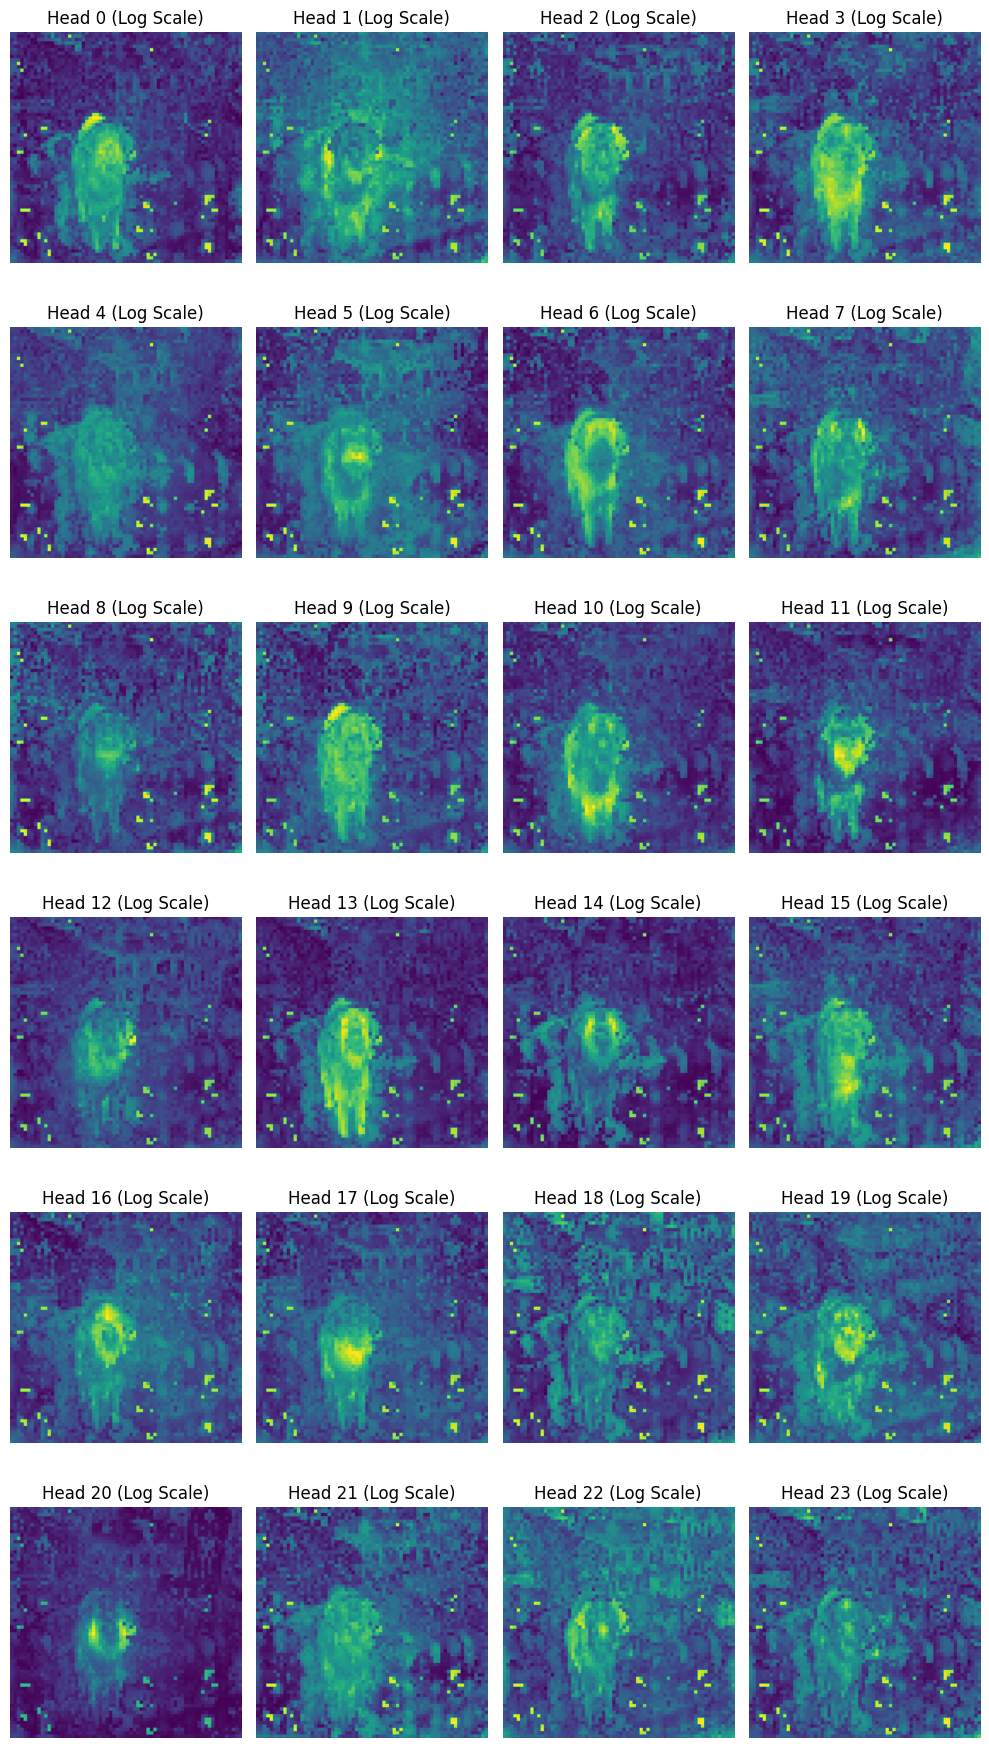

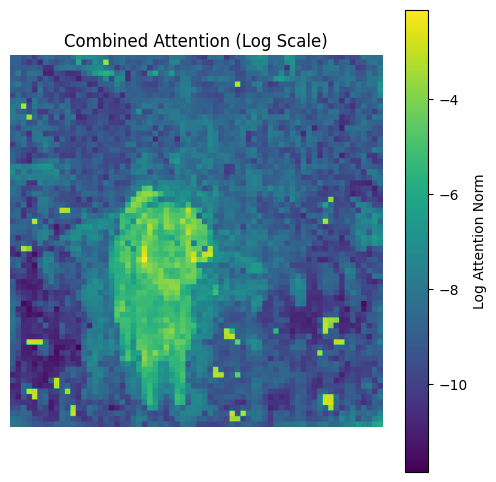

In [ ]:
# log scale visualization

epsilon = 1e-6  # small constant to prevent log(0)

log_attentions = np.log(attentions + epsilon)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, num_rows * 3))
for j in range(nh):
    row, col = divmod(j, num_cols)
    ax = axes[row, col]
    ax.imshow(log_attentions[j], cmap="viridis")
    ax.set_title(f"Head {j} (Log Scale)")
    ax.axis("off")

for idx in range(nh, num_rows * num_cols):
    axes[idx // num_cols, idx % num_cols].axis("off")

plt.tight_layout()
plt.show()

combined_attention_log = np.log(combined_attention + epsilon)

plt.figure(figsize=(6, 6))
plt.imshow(combined_attention_log, cmap="viridis")
plt.title("Combined Attention (Log Scale)")
plt.axis("off")
plt.colorbar(label="Log Attention Norm")
plt.show()

### Global attention check

Mean norm for high-attention patches: 249.5601043701172


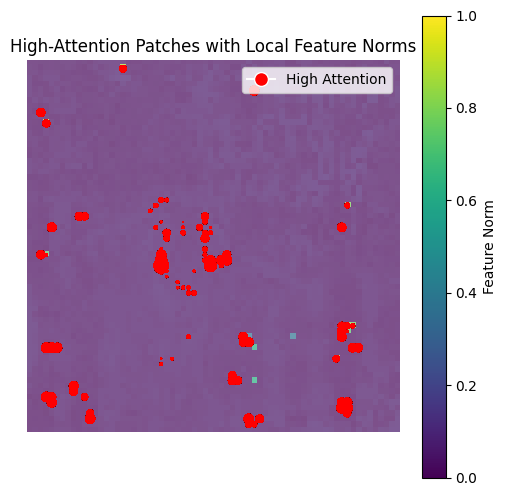

In [ ]:
# check if high norms correspond to high attention values

high_attention_threshold = np.percentile(combined_attention, 98)
high_attention_indices = np.where(combined_attention >= high_attention_threshold)

scale_factor = 196 // 14
scaled_attention_indices = (high_attention_indices[0] // scale_factor, high_attention_indices[1] // scale_factor)

attention_values = combined_attention[high_attention_indices]

high_attention_norms = local_feature_norms[0].cpu().numpy()[scaled_attention_indices]

mean_high_attention_norm = np.mean(high_attention_norms)
print(f"Mean norm for high-attention patches: {mean_high_attention_norm}")

dot_sizes = (attention_values - np.min(attention_values)) / (np.max(attention_values) - np.min(attention_values)) * 100
plt.figure(figsize=(6, 6))
plt.imshow(local_feature_norms[0].cpu().numpy(), cmap="viridis", alpha=0.7)
plt.scatter(scaled_attention_indices[1], scaled_attention_indices[0], color="red", s=dot_sizes)
plt.title("High-Attention Patches with Local Feature Norms")
plt.axis("off")
plt.colorbar(label="Feature Norm")
plt.legend(
    handles=[plt.Line2D([0], [0], marker='o', color='w', label='High Attention',
                        markerfacecolor='red', markersize=10)],
    loc='upper right', frameon=True, fontsize=10
)

plt.show()

In [16]:
# logistic regression norm-normal 3 seeds

seeds = [42, 123, 999]
train_subset_size = 800
test_subset_size = 200
batch_size = 100
high_norm_accuracies = []
normal_norm_accuracies = []

for seed in seeds:
    high_acc, normal_acc = run_3glo_g(seed)
    high_norm_accuracies.append(high_acc)
    normal_norm_accuracies.append(normal_acc)

avg_high_acc = np.mean(high_norm_accuracies)
avg_normal_acc = np.mean(normal_norm_accuracies)

print("\nAverage Results over 3 runs:")
print(f"Average High-Norm Token Accuracy: {avg_high_acc:.4f}")
print(f"Average Normal Token Accuracy: {avg_normal_acc:.4f}")


Running experiment with seed 42...
Files already downloaded and verified
Files already downloaded and verified
Subsets and DataLoaders ready.
DINOv2 model loaded and ready.
Extracting patch embeddings...
Processed batch 1/8
Processed batch 2/8
Processed batch 3/8
Processed batch 4/8
Processed batch 5/8
Processed batch 6/8
Processed batch 7/8
Processed batch 8/8
Patch embedding extraction complete.
800 800
800 800
Training Logistic Regression classifiers...
Evaluating classifiers...
High-Norm Token Accuracy: 0.9812
Normal Token Accuracy: 0.8562
Running experiment with seed 123...
Files already downloaded and verified
Files already downloaded and verified
Subsets and DataLoaders ready.
DINOv2 model loaded and ready.
Extracting patch embeddings...
Processed batch 1/8
Processed batch 2/8
Processed batch 3/8
Processed batch 4/8
Processed batch 5/8
Processed batch 6/8
Processed batch 7/8
Processed batch 8/8
Patch embedding extraction complete.
800 800
800 800
Training Logistic Regression cla

torch.Size([3, 700, 700])
torch.Size([1, 3, 700, 700])
Processing layer 0...
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Layer 0 completed in 16.20 seconds
Processing layer 1...
Layer 1 completed in 13.33 seconds
Processing layer 2...
Layer 2 completed in 13.66 seconds
Processing layer 3...
Layer 3 completed in 13.61 seconds
Processing layer 4...
Layer 4 completed in 13.51 seconds
Processing layer 5...
Layer 5 completed in 13.54 seconds
Processing layer 6...
Layer 6 completed in 13.37 seconds
Processing layer 7...
Layer 7 completed in 13.43 seconds
Processing layer 8...
Layer 8 completed in 13.57 seconds
Processing layer 9...
Layer 9 completed in 13.68 seconds
Processing layer 10...
Layer 10 completed in 13.47 seconds
Processing layer 11...
Layer 11 completed in 13.63 seconds
Process

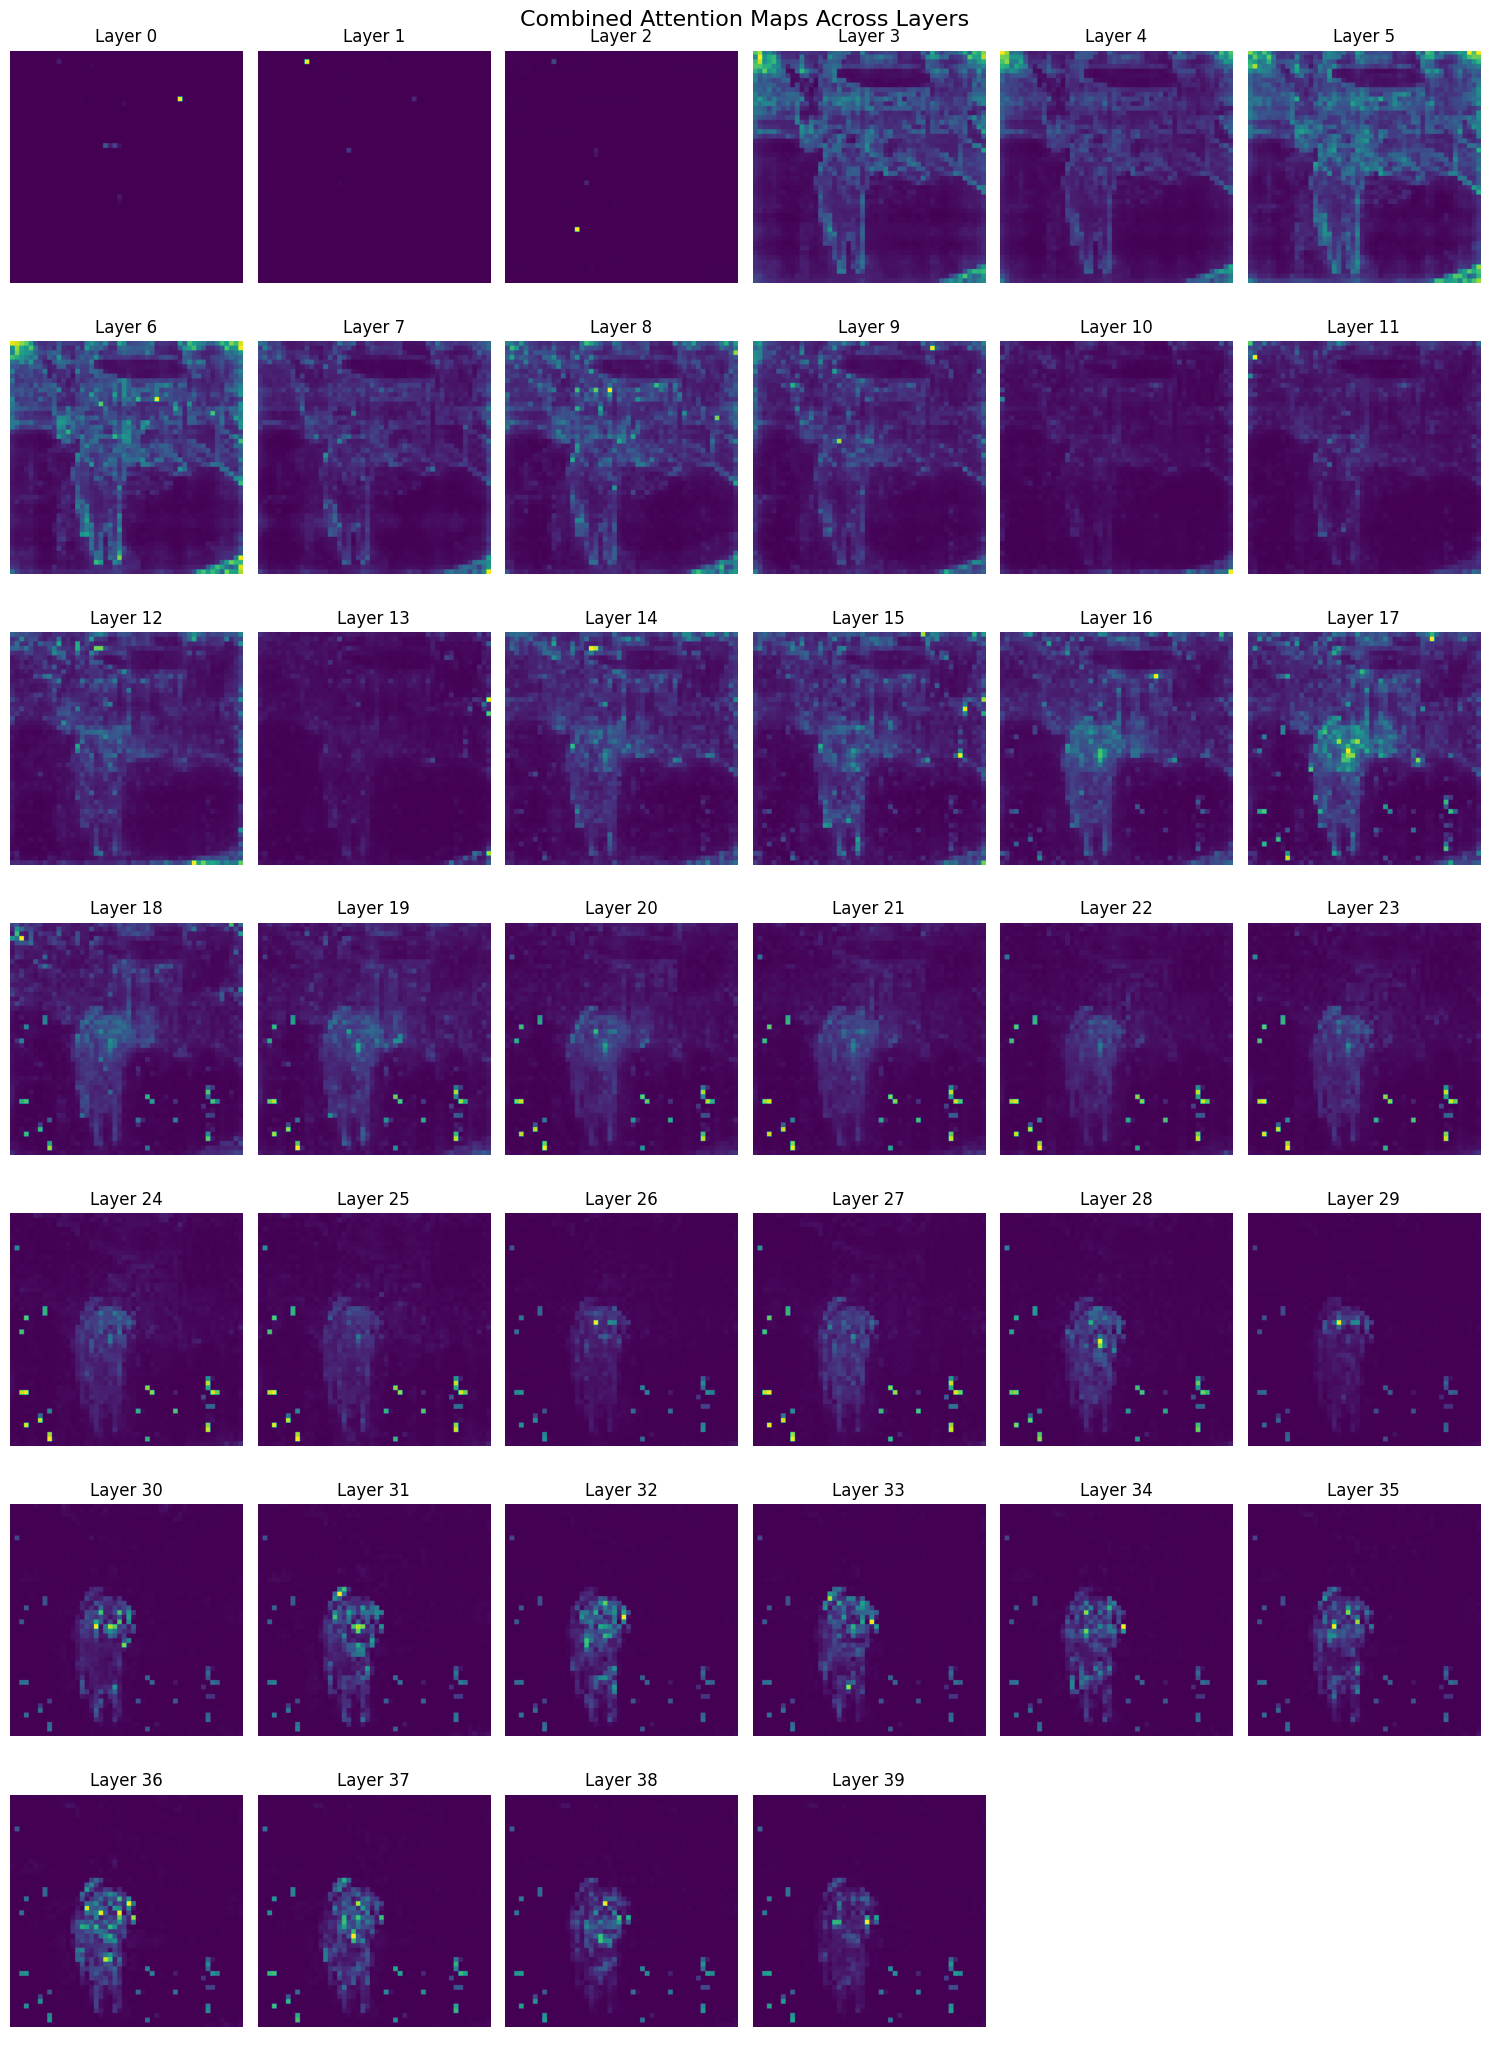

In [ ]:
# attention across layers
import time
if __name__ == '__main__':
    image_size = (700, 700) # lower resolution to avoid kernel crash
    output_dir = '.'
    patch_size = 14

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    model = dinov2_vitg14(
            patch_size=14,
            img_size=526,
            init_values=1.0,
            block_chunks=0
    )

    model.load_state_dict(torch.load('dinov2_vitg14_pretrain.pth'))
    for p in model.parameters():
        p.requires_grad = False
    model.to(device)
    model.eval()

    img = Image.open('dog.JPEG')
    img = img.convert('RGB')
    transform = pth_transforms.Compose([
        pth_transforms.Resize(image_size),
        pth_transforms.ToTensor(),
    ])
    img = transform(img)
    print(img.shape)

    w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - img.shape[2] % patch_size
    img = img[:, :w, :h].unsqueeze(0)

    w_featmap = img.shape[-2] // patch_size
    h_featmap = img.shape[-1] // patch_size

    print(img.shape)

    all_layer_attentions = []

    x = model.prepare_tokens_with_masks(img.to(device))
    for layer_idx, blk in enumerate(model.blocks):
        start_time = time.time()
        print(f"Processing layer {layer_idx}...")
        attention = blk(x, return_attention=True)
        all_layer_attentions.append(attention)
        x = blk(x)
        print(f"Layer {layer_idx} completed in {time.time() - start_time:.2f} seconds")
    num_layers = len(all_layer_attentions)
    num_cols = 6
    num_rows = (num_layers + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows*3))
    fig.suptitle("Combined Attention Maps Across Layers", fontsize=16)

    for layer_idx, attentions in enumerate(all_layer_attentions):
        nh = attentions.shape[1]
        attentions = attentions[0, :, 0, :]
        attentions = attentions[:, 1:].reshape(nh, w_featmap, h_featmap)
        attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()

        combined_attention = np.linalg.norm(attentions, axis=0)


        row, col = divmod(layer_idx, num_cols)
        ax = axes[row, col]
        ax.imshow(combined_attention, cmap="viridis")
        ax.set_title(f"Layer {layer_idx}")
        ax.axis("off")

    for idx in range(num_layers, num_rows * num_cols):
        row, col = divmod(idx, num_cols)
        axes[row, col].axis("off")

    plt.tight_layout()
    plt.show()


### Local attention check

In [17]:
# Position prediction 3 seeds

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = dinov2_vitg14(
    patch_size=14,
    img_size=526,
    init_values=1.0,
    block_chunks=0
)
model.load_state_dict(torch.load('dinov2_vitg14_pretrain.pth'))
for p in model.parameters():
    p.requires_grad = False
model.to(device)
model.eval()

transform = pth_transforms.Compose([
    pth_transforms.Resize((196, 196)),
    pth_transforms.ToTensor()
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_subset_size = 800
test_subset_size = 200
train_indices = torch.randperm(len(train_dataset))[:train_subset_size]
test_indices = torch.randperm(len(test_dataset))[:test_subset_size]
train_subset = Subset(train_dataset, train_indices)
test_subset = Subset(test_dataset, test_indices)

train_loader = DataLoader(train_subset, batch_size=10, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=10, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [18]:
train_embeddings, train_positions, train_norms = extract_features_loc(model, train_loader)
test_embeddings, test_positions, test_norms = extract_features_loc(model, test_loader)

high_indices = train_norms > 100
normal_indices = ~high_indices

X_high = train_embeddings[high_indices]
y_high = train_positions[high_indices]
X_normal = train_embeddings[normal_indices]
y_normal = train_positions[normal_indices]

Extracting patch embeddings and positional information...
Complete.
Extracting patch embeddings and positional information...
Complete.


In [19]:
high_norm_top1_accs = []
high_norm_avg_distances = []
normal_top1_accs = []
normal_avg_distances = []
seeds = [42, 123, 999]

for seed in seeds:
    print(f"Running experiment with seed {seed}...")
    high_top1_acc, high_avg_dist, normal_top1_acc, normal_avg_dist = run_3loc(seed, X_high, X_normal, y_high, y_normal)
    high_norm_top1_accs.append(high_top1_acc)
    high_norm_avg_distances.append(high_avg_dist)
    normal_top1_accs.append(normal_top1_acc)
    normal_avg_distances.append(normal_avg_dist)

high_top1_acc_mean = np.mean(high_norm_top1_accs)
high_avg_dist_mean = np.mean(high_norm_avg_distances)
normal_top1_acc_mean = np.mean(normal_top1_accs)
normal_avg_dist_mean = np.mean(normal_avg_distances)

print("\nAverage Results over 3 runs:")
print(f"High-Norm Tokens - Avg Top-1 Accuracy: {high_top1_acc_mean:.2f}% | Avg Distance: {high_avg_dist_mean:.2f}")
print(f"Normal Tokens - Avg Top-1 Accuracy: {normal_top1_acc_mean:.2f}% | Avg Distance: {normal_avg_dist_mean:.2f}")

Running experiment with seed 42...
Running experiment with seed 123...
Running experiment with seed 999...

Average Results over 3 runs:
High-Norm Tokens - Avg Top-1 Accuracy: 14.68% | Avg Distance: 1.36
Normal Tokens - Avg Top-1 Accuracy: 16.03% | Avg Distance: 1.27


## DINOV2 WITH REG G

In [ ]:
if __name__ == '__main__':
    image_size = (952, 952)
    output_dir = '.'
    patch_size = 14

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    model_reg = dinov2_vitg14_reg(
        patch_size=14,
        img_size=526,
        init_values=1.0,
        block_chunks=0,
        num_register_tokens=4,
    )

    state_dict = torch.load('dinov2_vitg14_reg4_pretrain.pth')
    model_reg.load_state_dict(state_dict, strict=True)

    for p in model_reg.parameters():
        p.requires_grad = False
    model_reg.to(device)
    model_reg.eval()

    img = Image.open('dog.JPEG')
    img = img.convert('RGB')
    transform = pth_transforms.Compose([
        pth_transforms.Resize(image_size),
        pth_transforms.ToTensor(),
    ])
    img = transform(img)
    w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - img.shape[2] % patch_size
    img = img[:, :w, :h].unsqueeze(0)

    w_featmap = img.shape[-2] // patch_size
    h_featmap = img.shape[-1] // patch_size
    print(f"Feature map size: {w_featmap} x {h_featmap}")

    attentions = model_reg.get_last_self_attention(img.to(device))
    nh = attentions.shape[1]

    attentions = attentions[0, :, 0, :]
    num_patches = w_featmap * h_featmap
    expected_tokens = 1 + 4 + num_patches
    if attentions.size(1) != expected_tokens:
        raise RuntimeError(
            f"Token mismatch: expected {expected_tokens} tokens, but got {attentions.size(1)} tokens."
        )

    attentions = torch.cat([attentions[:, :1], attentions[:, 5:]], dim=1)
    attentions = attentions[:, 1:].reshape(nh, w_featmap, h_featmap)

    attentions = nn.functional.interpolate(
        attentions.unsqueeze(0), scale_factor=patch_size, mode="nearest"
    )[0].cpu().numpy()

Feature map size: 68 x 68
Inside get_last_self_attention
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


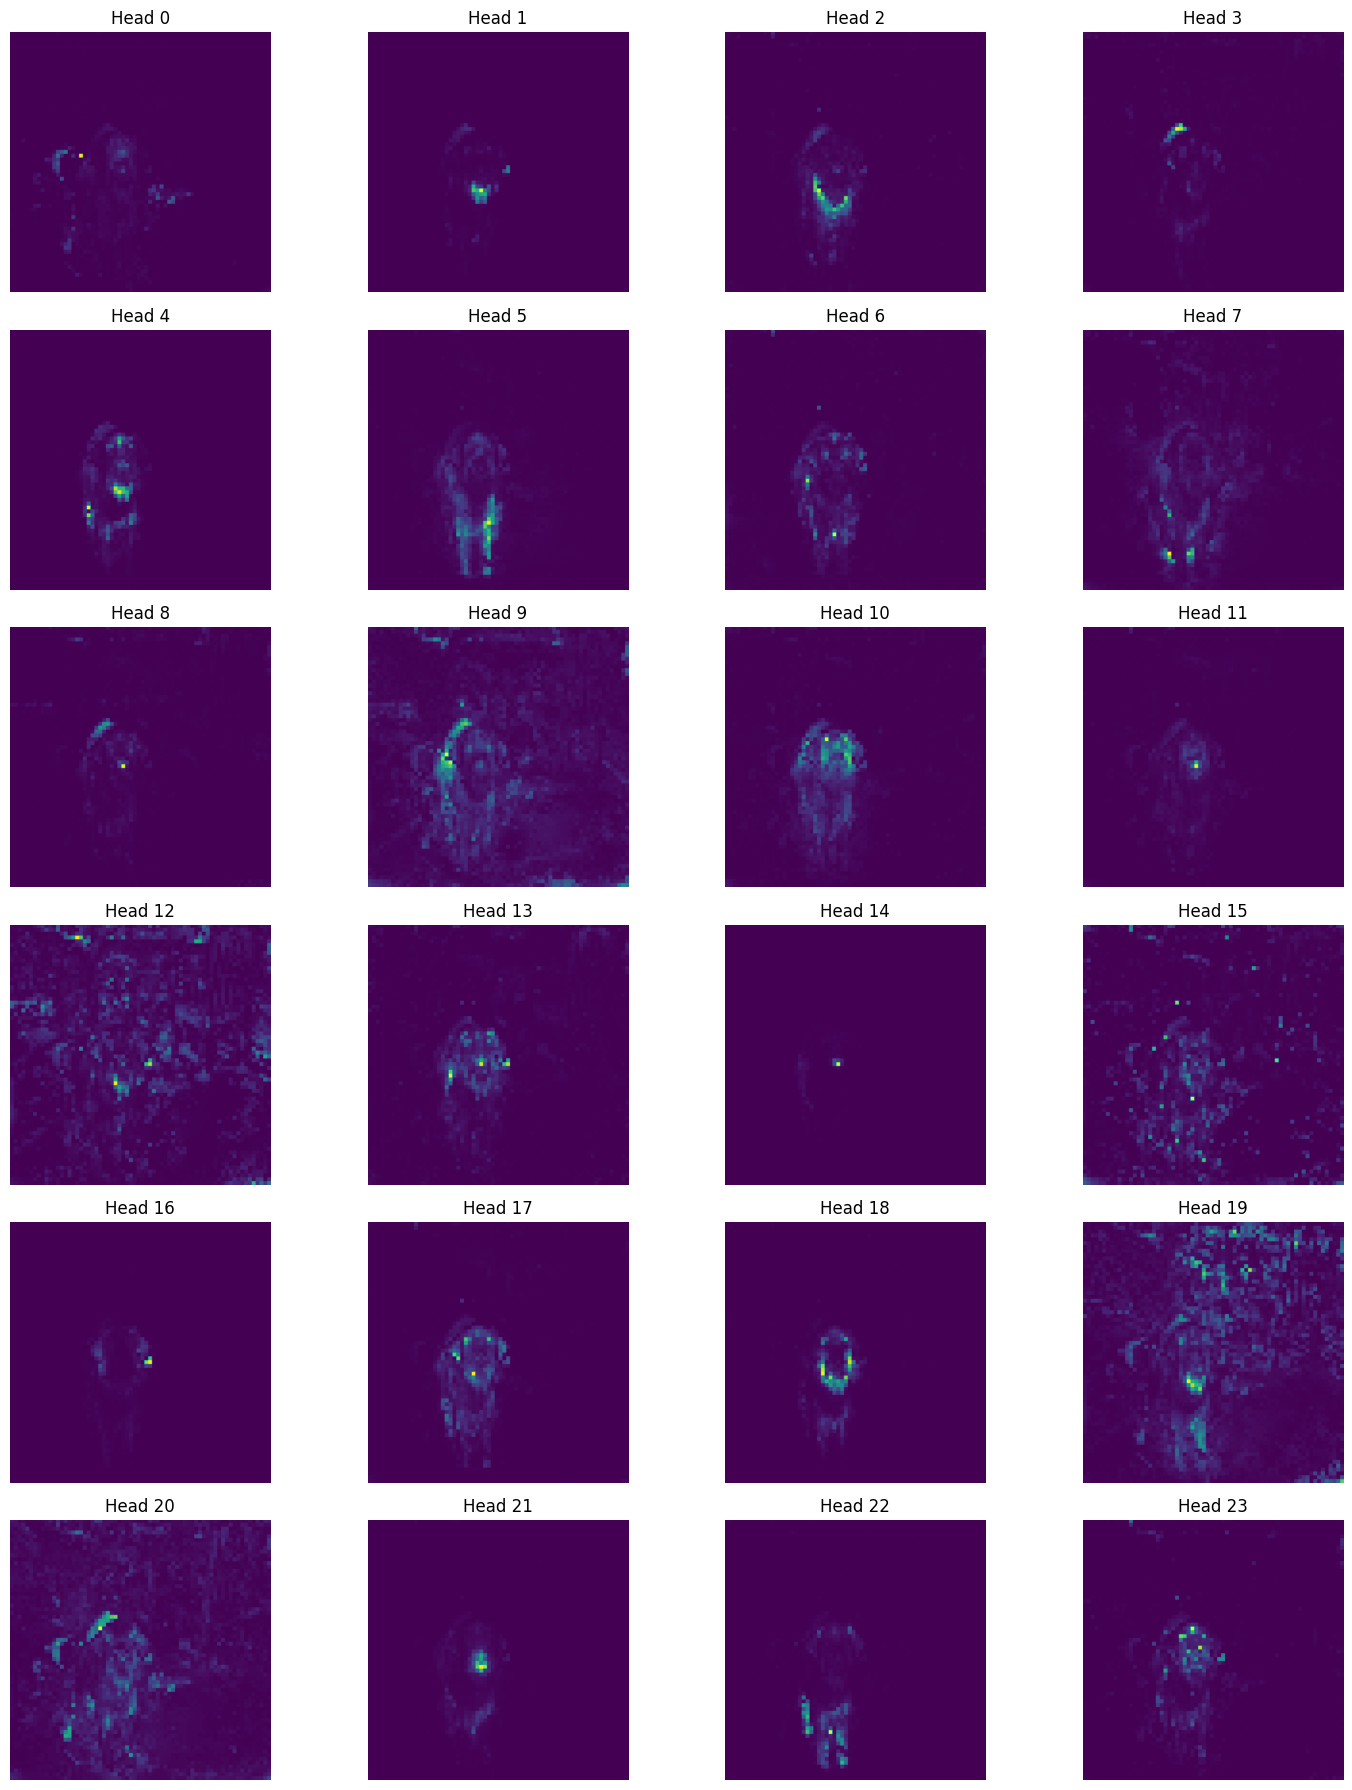

In [ ]:

num_cols = 4
num_rows = (nh + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))

for j in range(nh):
    row, col = divmod(j, num_cols)
    ax = axes[row, col]
    ax.imshow(attentions[j], cmap="viridis")
    ax.set_title(f"Head {j}")
    ax.axis("off")

for idx in range(nh, num_rows * num_cols):
    axes[idx // num_cols, idx % num_cols].axis("off")

plt.tight_layout()
plt.show()


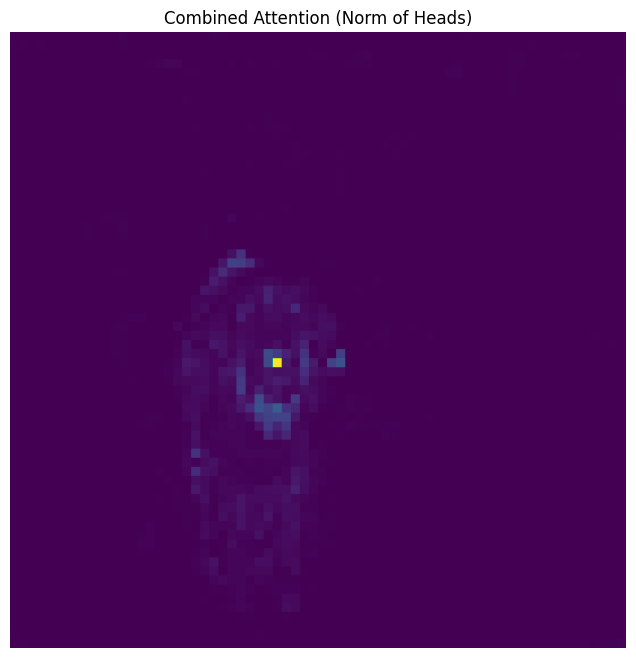

In [ ]:
# DINOV2 HEAD NORM

combined_attention = np.linalg.norm(attentions, axis=0)

plt.figure(figsize=(8, 8))
plt.imshow(combined_attention, cmap="viridis")
plt.title("Combined Attention (Norm of Heads)")
plt.axis("off")
#plt.colorbar(label="Attention Norm")
plt.show()

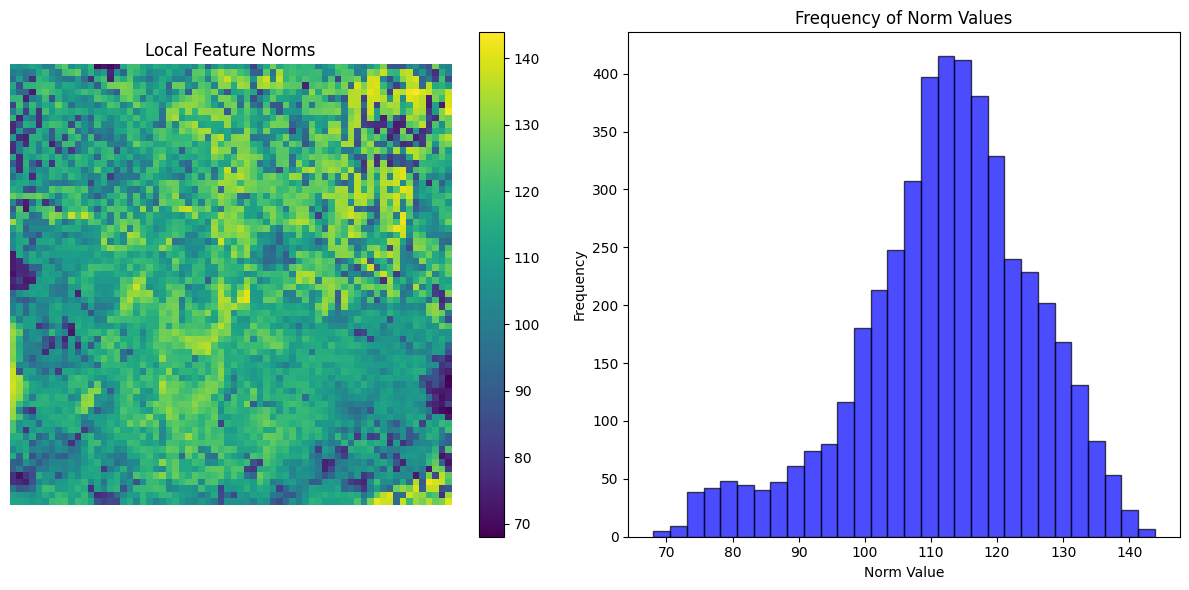

In [ ]:
# DINOV2 NORMS WITH REGISTERS

features = model_reg.forward_features(img)["x_prenorm"]
patch_features = features[:, 1 + 4:, :]
local_feature_norms = torch.norm(patch_features, dim=-1)
w_featmap = img.shape[-2] // patch_size
h_featmap = img.shape[-1] // patch_size


num_patches = patch_features.shape[1]
local_feature_norms = local_feature_norms.reshape(-1, w_featmap, h_featmap)

flattened_norms = local_feature_norms[0].cpu().numpy().flatten()
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(local_feature_norms[0].cpu().numpy(), cmap="viridis")
plt.colorbar()
plt.title("Local Feature Norms")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.hist(flattened_norms, bins=30, color="blue", alpha=0.7, edgecolor="black")
plt.title("Frequency of Norm Values")
plt.xlabel("Norm Value")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

## PERFORMANCE REGRESSION WITH/WITHOUT REG G

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_no_reg = vit_large(
    patch_size=14,
    img_size=526,
    init_values=1.0,
    block_chunks=0
)
model_no_reg.load_state_dict(torch.load('dinov2_vitl14_pretrain.pth'))
model_no_reg.to(device)
model_no_reg.eval()

model_with_reg = vit_large(
    patch_size=14,
    img_size=526,
    init_values=1.0,
    block_chunks=0,
    num_register_tokens=4
)
model_with_reg.load_state_dict(torch.load('dinov2_vitl14_reg4_pretrain.pth'))
model_with_reg.to(device)
model_with_reg.eval()

transform = pth_transforms.Compose([
    pth_transforms.Resize((196, 196)),
    pth_transforms.ToTensor()
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_subset_size = 800
test_subset_size = 200
train_indices = torch.randperm(len(train_dataset))[:train_subset_size]
test_indices = torch.randperm(len(test_dataset))[:test_subset_size]

train_subset = Subset(train_dataset, train_indices)
test_subset = Subset(test_dataset, test_indices)
train_loader = DataLoader(train_subset, batch_size=10, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=10, shuffle=False)

print("Extracting features for model without registers...")
train_features_no_reg, train_labels_no_reg = extract_features(model_no_reg, train_loader)
test_features_no_reg, test_labels_no_reg = extract_features(model_no_reg, test_loader)

print("Extracting features for model with registers...")
train_features_with_reg, train_labels_with_reg = extract_features(model_with_reg, train_loader)
test_features_with_reg, test_labels_with_reg = extract_features(model_with_reg, test_loader)

print("Evaluating model without registers...")
accuracy_no_reg = evaluate_linear_probe(
    train_features_no_reg, train_labels_no_reg,
    test_features_no_reg, test_labels_no_reg
)

print("Evaluating model with registers...")
accuracy_with_reg = evaluate_linear_probe(
    train_features_with_reg, train_labels_with_reg,
    test_features_with_reg, test_labels_with_reg
)

print(f"Accuracy without registers: {accuracy_no_reg:.4f}")
print(f"Accuracy with registers: {accuracy_with_reg:.4f}")

Files already downloaded and verified
Files already downloaded and verified
Extracting features for model without registers...
Extracting features for model with registers...
Evaluating model without registers...
Evaluating model with registers...
Accuracy without registers: 0.9700
Accuracy with registers: 0.9750
